**NOTE** this notebook is supposed to represent the final work implementation for the model based on the different training experimentations done in the previous notebooks for training and tuning.

## Import

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

In [4]:
df = pd.read_csv('../Data/processed/dfd_cle_RR_viz_pow.csv')

In [6]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    
    # iterate through all the columns of a dataframe and modify the data type
    #   to reduce memory usage.        
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
df_optimized = reduce_mem_usage(df)

Memory usage of dataframe is 973.25 MB
Memory usage after optimization is: 343.99 MB
Decreased by 64.7%


## Preprocessing

In [13]:
if ('Id' in df_optimized.columns) or ('groupId' in df_optimized.columns) or ('matchId' in df_optimized.columns):
        df_optimized = df_optimized.drop(columns=['Id', 'groupId', 'matchId'], axis=1)

In [18]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df_optimized[['matchType']])

new_arrs = enc.transform(df_optimized[['matchType']]).toarray()
new_arrs = pd.DataFrame(data=new_arrs, columns = [f'matchType_dum {i}' for i in range(1, new_arrs.shape[1] + 1)])
df_optimized = df_optimized.drop(columns=['matchType'], axis=1)
df_optimized = pd.concat([df_optimized, new_arrs], axis=1)

In [19]:
df_optimized.head().T

,0,1,2,3,4
assists,-0.456787,-0.456787,2.183594,-0.456787,-0.456787
boosts,-0.841797,-0.841797,-0.841797,-0.841797,-0.841797
damageDealt,-1.394531,0.322510,0.154175,-0.213013,0.375244
DBNOs,-0.765625,-0.765625,-0.765625,-0.765625,-0.765625
headshotKills,-0.446045,-0.446045,-0.446045,-0.446045,-0.446045
heals,-0.793457,-0.793457,-0.793457,-0.793457,-0.793457
killPlace,0.498047,0.399658,0.061096,0.970703,-0.008972
killPoints,1.217773,-0.821777,-0.821777,-0.821777,-0.821777
kills,-0.843262,-0.843262,-0.843262,-0.843262,0.805664
killStreaks,-0.855957,-0.855957,-0.855957,-0.855957,1.025391


In [20]:
X = df_optimized.drop(['winPlacePerc'], axis=1)
y = df_optimized['winPlacePerc']  

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4354820, 40), (4354820,), (43989, 40), (43989,))

In [66]:
rmse_cv = {}
acc_cv = {}

def rmsle_cv(model, model_name):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    acc = cross_val_score(model, X_train.values, y_train, cv = kf)
    rmse_cv[model_name] = rmse.mean()
    acc_cv[model_name] = acc.mean()
    
    return (rmse)

## Model

#### way 1 of building model 

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y): 
    print("Train:", train_index, "Validation:", val_index) 
    X_train, X_test = X[train_index], X[val_index] 
    y_train, y_test = y[train_index], y[val_index]

In [87]:
#Validation function
n_folds = 5

rmse_cv = {}
acc_cv = {}

def rmsle_cv(model, model_name):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    acc = cross_val_score(model, X_train.values, y_train, cv = kf)
    rmse_cv  = rmse.mean()
    acc_cv[  = acc.mean()
    
    return (rmse)

In [84]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=50,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, silent=True)

# experiment 3 hyperparameters
# model_lgb = lgb.LGBMRegressor(objective='regression', 
                              
#                               reg_alpha=0.0016643092201414056,
#                               reg_lambda=0.17444450082323898, colsample_bytree=0.5,
#                               subsample=0.5, learning_rate=0.01, max_depth=20,
#                               num_leaves=793, min_child_samples=5, min_data_per_groups=66,
                              
#                               n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, silent=True)

In [85]:
model_lgb.fit(X_train, y_train)

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
              feature_fraction=0.2319, feature_fraction_seed=9,
              learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
              min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=50,
              objective='regression', silent=True)

In [103]:
# manually tuned model results
expected = y_test.reset_index(drop=True)
predicted = model_lgb.predict(X_test)

RMSE = mean_squared_error(expected, predicted, squared=False)
MSE = mean_squared_error(expected, predicted)
MAE = mean_absolute_error(expected, predicted)

print('model results')
print("MSE: %.5f" % MSE)
print("RMSE: %.5f" % RMSE) 
print("MAE: %.5f" % MAE) 
print('-' * 50)

model results
MSE: 0.00790
RMSE: 0.08887
MAE: 0.06369
--------------------------------------------------


In [89]:
n_folds = 5
kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
rmse= np.sqrt(-cross_val_score(model_lgb, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
acc = cross_val_score(model_lgb, X_train.values, y_train, cv = kf)
rmse_cv  = rmse.mean()
acc_cv  = acc.mean()
       
print("RMSE (CV): %.5f" % rmse_cv) 
print("ACC (CV): %.5f" % acc_cv) 

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
RMSE (CV): 0.08887
ACC (CV): 0.91575


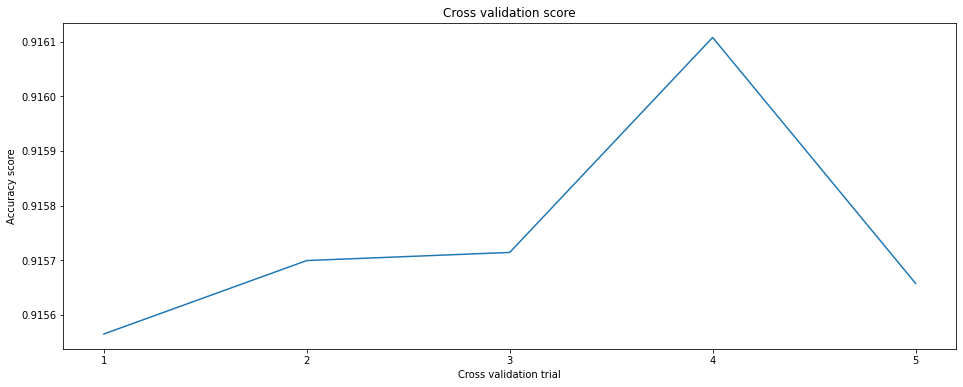

In [125]:
# plotting cv results

trials = np.arange(n_folds) + 1
plt.figure(figsize=(16,6))

plt.plot(trials, acc)
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Cross validation trial')
plt.ylabel('Accuracy score')
plt.title("Cross validation score")
# plt.legend(['test score', 'train score'], loc='upper left')
plt.xticks(trials)
plt.show()

In [63]:
# experiment 3 results
expected = y_test.reset_index(drop=True)
predicted = model_lgb.predict(X_test)

RMSE = mean_squared_error(expected, predicted, squared=False)
MSE = mean_squared_error(expected, predicted)
MAE = mean_absolute_error(expected, predicted)

print('model results')
print("MSE: %.5f" % MSE)
print("RMSE: %.5f" % RMSE) 
print("MAE: %.5f" % MAE) 
print('-' * 50)

model results
MSE: 0.01080
RMSE: 0.10392
MAE: 0.07649
--------------------------------------------------


#### way 2 of building model (provides better results by better training procedure)

In [141]:
# manual tuning parameters
# params = {
#     "objective": 'regression',
#     "num_leaves": 50,
#     "learning_rate": 0.05,
#     "n_estimators": 720,
# #     "max_bin": 55,
#     "bagging_fraction":0.8,
#     "bagging_freq":5,
#     "feature_fraction":0.2319,
#     "feature_fraction_seed":9,
#     "bagging_seed":9,
#     "min_data_in_leaf":6,
#     "min_sum_hessian_in_leaf":11,
#     "silent":True
# }


# experiment 3 parameters 
params = {
    "reg_alpha": 0.0016643092201414056,
    "reg_lambda": 0.17444450082323898, 
    'colsample_bytree': 0.5,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'max_depth': 20,
    'num_leaves': 793,
     'min_child_samples': 77,
    'min_data_per_groups': 93
}

In [65]:
dataset_params = {
    "max_bin": 55
}

lgb_train = lgb.Dataset(X_train, y_train, params=dataset_params)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, params=dataset_params)

In [101]:
model_1 = lgb.train(params, 
                    train_set = lgb_train,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=lgb_eval
)

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 4354820, number of used features: 40
[LightGBM] [Info] Start training from score 0.468943
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.0126245
[200]	valid_0's l2: 0.0102887
[300]	valid_0's l2: 0.00936787
[400]	valid_0's l2: 0.00886551
[500]	valid_0's l2: 0.00849008
[600]	valid_0's l2: 0.0081025
[700]	valid_0's l2: 0.00792823

In [102]:
# manual-tuned results
y_pred = model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(y_test, y_pred)
print('model results')
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % rmse) 
print("MAE: %.5f" % mae) 
print('-' * 50)

model results
MSE: 0.00790
RMSE: 0.08887
MAE: 0.06369
--------------------------------------------------


In [83]:
# experiment 3 results
y_pred = model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
mae = mean_absolute_error(y_test, y_pred)
print('model results')
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % rmse) 
print("MAE: %.5f" % mae) 
print('-' * 50)

model results
MSE: 0.00668
RMSE: 0.08174
MAE: 0.05829
--------------------------------------------------


In [ ]:
k = 5
folds = np.array_split(df_optimized, k)
dataset_params = {
    "max_bin": 55
}

MAE_cv_final = {}
RMSE_cv_final = {}

for i in range(k):
    train = folds.copy() #you wanna work on a copy of your array
    test = folds[i]
    del train[i]
    train = pd.concat(train, sort=False)
    X_test, y_test = test.drop(['winPlacePerc'], axis=1), test['winPlacePerc'] 
    X_train, y_train = train.drop(['winPlacePerc'], axis=1), train['winPlacePerc'] 
    
    lgb_train_i = lgb.Dataset(X_train, y_train, params=dataset_params)
    lgb_eval_i = lgb.Dataset(X_test, y_test, reference=lgb_train, params=dataset_params)
    
    # experimentaion 3 hyperparameters (provides better results on way 2)
    model_1i = lgb.train(params, 
                    train_set = lgb_train_i,
                    num_boost_round=9400,
                    early_stopping_rounds=200,
                    verbose_eval=100, 
                    valid_sets=lgb_eval_i
    )
    
    y_pred = model_1i.predict(X_test)
    rmse = (mean_squared_error(y_test, y_pred))**(0.5)
    mae = mean_absolute_error(y_test, y_pred)
    MAE_cv_final[f'fold {i + 1}'] = mae
    RMSE_cv_final[f'fold {i + 1}'] = rmse
    
    
#     perform(clf, train.copy(), test.copy()) // do the fitting, here you also want to copy

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 3519047, number of used features: 40
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.468913
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.0253715
[200]	valid_0's l2: 0.0121496
[300]	valid_0's l2: 0.00912426
[400]	valid_0's l2: 0.00813958
[500]	valid_0's l2: 0.00771145
[600]	valid_0's l2: 0.00748485
[700

[7600]	valid_0's l2: 0.00677967
[7700]	valid_0's l2: 0.00677872
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7800]	valid_0's l2: 0.00677745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7900]	valid_0's l2: 0.00677615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8000]	valid_0's l2: 0.00677511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 3519047, number of used features: 40
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.468941
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.0253689
[200]	valid_0's l2: 0.0121652
[300]	valid_0's l2: 0.00914083
[400]	valid_0's l2: 0.00815596
[500]	valid_0's l2: 0.00772623
[600]	valid_0's l2: 0.00749854
[700

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7300]	valid_0's l2: 0.00678603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7400]	valid_0's l2: 0.00678471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7500]	valid_0's l2: 0.00678321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7600]	valid_0's l2: 0.00678229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7700]	valid_0's l2: 0.00678089
[7800]	valid_0's l2: 0.00677965
[7900]	valid_0's l2: 0.00677839
[LightGBM] [Warning] No fu

C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\modaj\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 3519047, number of used features: 40
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.468948
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 0.0253744
[200]	valid_0's l2: 0.0121677
[300]	valid_0's l2: 0.00914378
[400]	valid_0's l2: 0.00815739
[500]	valid_0's l2: 0.00772796
[600]	valid_0's l2: 0.00749994
[700